<a href="https://colab.research.google.com/github/bkokalari/User-reviews-moderation-with-deep-learning/blob/main/English/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing dependencies

In [ ]:
import pandas as pd
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
import re
import string
import spacy

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

#Data Import

In [ ]:
#path_root = "/content/drive/My Drive/reviews_ml/v2/English/"
revs_preprocessed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/English/augmented_data_english.csv") 
revs_preprocessed = revs_preprocessed.dropna()
revs_preprocessed['TranslatedReview'] = revs_preprocessed['TranslatedReview'].astype(str)
revs_preprocessed.sample(5)

,TranslatedReview,Approved
52206,He listened to me carefully and seemed to have...,1
91751,Mr. Parisis was fully understood in the matter...,1
15561,"The doctor was very kind, calm. He examined me...",1
38852,"Excellent doctor, very friendly, with a lot of...",1
70319,I highly recommend him,1


In [ ]:
revs = revs_preprocessed

revs0 = revs[(revs.Approved == "0")]
revs1 = revs[(revs.Approved == "1")]
revs = pd.concat([revs0, revs1], ignore_index=True).sample(frac=1)
revs.Approved = revs.Approved.astype(int)

revs.Approved.value_counts()

1    123099
0      8472
Name: Approved, dtype: int64

#Preprocessing

In [ ]:
punctuations = string.punctuation

def remove_punctuation(text):
  punctuated_string = text
  unpunctuated_string = punctuated_string.translate(str.maketrans(' ', ' ', string.punctuation))
  return unpunctuated_string

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [ ]:
revs["TranslatedReview"] = revs.TranslatedReview.map(lambda x: remove_emoji(x))
revs["TranslatedReview"] = revs.TranslatedReview.map(lambda x: remove_punctuation(x))

In [ ]:
data_clean = revs.TranslatedReview
data_labels = revs.Approved.values

In [ ]:
data_labels

array([1, 1, 1, ..., 1, 1, 1])

#Tokenization

In [ ]:
sp = spacy.load('en_core_web_sm')

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#Padding

In [ ]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

In [ ]:
data_inputs

array([[2007,   80, 1520, ...,    0,    0,    0],
       [ 111,   45,   69, ...,    0,    0,    0],
       [  26,    5,    6, ...,    0,    0,    0],
       ...,
       [  26,  446,  129, ...,    0,    0,    0],
       [   2,    8,    6, ...,    0,    0,    0],
       [  83,    8,   25, ...,    0,    0,    0]], dtype=int32)

# Split dataset

In [ ]:
# sss: stratified shuffle split

# We will use this object to split the raw dataset in Train - Test in a stratified manner.

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)

test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [ ]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [ ]:
#reviews = revs.TranslatedReview
#approval = revs.Approved

In [ ]:
'''# splitting in train-val and test

X_train_val, X_test, y_train_val, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(data_clean, data_labels):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = data_clean.iloc[train_index], data_clean.iloc[test_index]
    y_train_val, y_test = data_labels[train_index], data_labels[test_index]'''

'# splitting in train-val and test\n\nX_train_val, X_test, y_train_val, y_test = None, None, None, None\n\n# getting the indexes for each dataset\nfor train_index, test_index in test_sss.split(data_clean, data_labels):\n    \n    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])\n    \n    X_train_val, X_test = data_clean.iloc[train_index], data_clean.iloc[test_index]\n    y_train_val, y_test = data_labels[train_index], data_labels[test_index]'

In [ ]:
'''# We reset the indexes for bot the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)'''

'# We reset the indexes for bot the X-train-val and y-train-val in order to break them \n# again into two subsets.\nX_train_val = X_train_val.reset_index(drop=True)\ny_train_val = y_train_val.reset_index(drop=True)'

In [ ]:
'''# splitting the train-val dataset into train and validation dataset

X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]'''

'# splitting the train-val dataset into train and validation dataset\n\nX_train, X_val, y_train, y_val = None, None, None, None\n\nfor train_index, val_index in val_sss.split(X_train_val, y_train_val):\n    \n    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])\n    \n    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]\n    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]'

In [ ]:
'''print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))'''

"print('X_train_val shape: {}'.format(X_train_val.shape))\nprint('y_train_val shape: {}'.format(y_train_val.shape))\nprint()\n\nprint('X_train shape: {}'.format(X_train.shape))\nprint('y_train shape: {}'.format(y_train.shape))\nprint()\n\nprint('X_val shape: {}'.format(X_val.shape))\nprint('y_val shape: {}'.format(y_val.shape))\n\nprint()\nprint('X_test shape: {}'.format(X_test.shape))\nprint('y_test shape: {}'.format(y_test.shape))"

#Split 2

In [ ]:
test_idx = np.random.randint(0, 100000, 21000)
text_idx = np.concatenate((test_idx, test_idx+100000))

In [ ]:
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

#Model building

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               FFN_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=False,
               name="dcnn"):
      super(DCNN, self).__init__(name=name)

      self.embedding = layers.Embedding(vocab_size,
                                        emb_dim)
      self.bigram = layers.Conv1D(filters=nb_filters, #filter along 1 dimension
                                  kernel_size=2,
                                  padding="valid",
                                  activation="relu")
      self.pool_1 = layers.GlobalMaxPool1D()
      self.trigram = layers.Conv1D(filters=nb_filters, #filter along 1 dimension
                                  kernel_size=3,
                                  padding="valid",
                                  activation="relu")
      self.pool_2 = layers.GlobalMaxPool1D()
      self.fourgram = layers.Conv1D(filters=nb_filters, #filter along 1 dimension
                                  kernel_size=4,
                                  padding="valid",
                                  activation="relu")
      self.pool_3 = layers.GlobalMaxPool1D()
      self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
      self.dropout = layers.Dropout(rate=dropout_rate)
      if nb_classes == 2:
        self.last_dense = layers.Dense(units=1,
                                       activation="sigmoid")
      else:
        self.last_dense = layers.Dense(units=nb_classes,
                                       activation="softmax")
        
  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool_1(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool_1(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool_1(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batches_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Application

## Config

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 32
NB_EPOCHS = 5

## Training

In [ ]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [ ]:

if NB_CLASSES == 2:
  Dcnn.compile(loss="binary_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])
else:
  Dcnn.compile(loss="sparse_categorical_crossentropy",
               optimizer="adam",
               metrics=["sparse_categorical_accuracy"])

In [ ]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/CNN_for_NLP/ckpt/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored!")

Latest checkpoint restored!


In [ ]:
Dcnn.fit(train_inputs,
         train_labels,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
ckpt_manager.save()

Epoch 1/5


KeyboardInterrupt: ignored

#Evaluation

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

657/657 [==============================] - 8s 12ms/step - loss: 0.0308 - accuracy: 0.9926
[0.030813004821538925, 0.9926190376281738]


In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(results)

657/657 [==============================] - 7s 11ms/step - loss: 0.1292 - accuracy: 0.9735
[0.12916888296604156, 0.9734761714935303]


In [ ]:
Dcnn(np.array([tokenizer.encode("what an asshole was that")]), training=False).numpy()

array([[0.00024943]], dtype=float32)

In [ ]:
Dcnn(np.array([tokenizer.encode("great doctor!!")]), training=False).numpy()

array([[0.99965775]], dtype=float32)

In [ ]:
predicted = Dcnn.predict(test_inputs) #change val and test
predicted = tf.greater(predicted, .5)

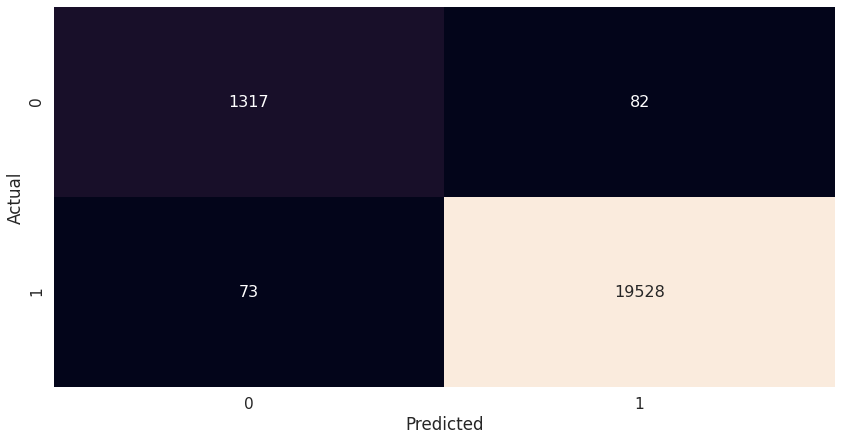

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

array_final = confusion_matrix(test_labels, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

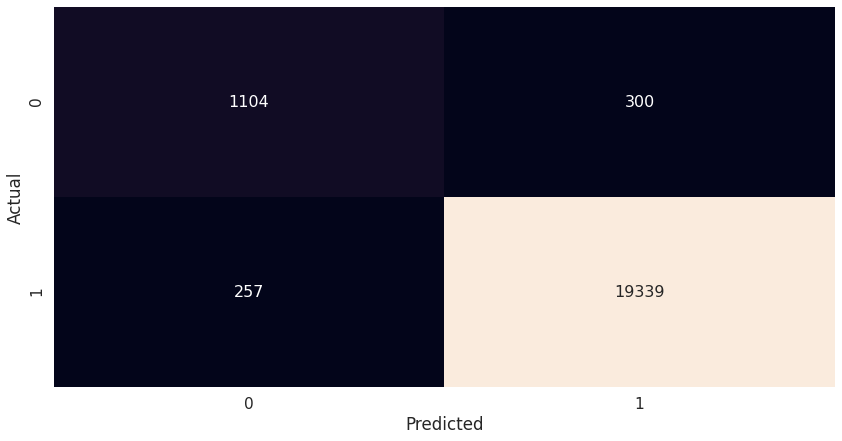

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

array_final = confusion_matrix(test_labels, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})